In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd

Mounted at /content/drive


In [2]:
data = pd.read_csv("/content/drive/MyDrive/sms+spam+collection/SMSSpamCollection", sep='\t', header=None, names=['label', 'text'])




In [3]:
data

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "/content/drive/MyDrive/sms+spam+collection/SMSSpamCollection"
data = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'message'])


In [9]:

# Preprocessing: convert labels to binary (spam: 1, ham: 0)
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Tokenization: convert messages to character n-grams with Out-Of-Vocabulary (OOV) handling
def tokenize_message(message, vocab, n=3):
    # Tokenize the message into character n-grams
    tokens = [message[i:i+n] if message[i:i+n] in vocab else '<u>' for i in range(len(message)-n+1)]
    return tokens

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])        #stratify is used to check for uneveness in training data

# Build vocabulary
def build_vocab(data, n=3):
    # Initialize an empty set to store unique n-grams
    vocab = set()
    # Iterate through each message in the dataset
    for message in data['message']:
        # Extract all character n-grams from the message and add them to the vocabulary set
        for i in range(len(message)-n+1):
            vocab.add(message[i:i+n])
    return vocab

# Build vocabulary from the training data
vocab = build_vocab(train_data)

# Replace Out-Of-Vocabulary (OOV) tokens with '<u>'
train_data['tokens'] = train_data['message'].apply(lambda x: tokenize_message(x, vocab))
test_data['tokens'] = test_data['message'].apply(lambda x: tokenize_message(x, vocab))


In [13]:

# Function to train Gaussian Naive Bayes classifier
def train_gaussian_nb(data):
    # Initialize a defaultdict to store counts of each n-gram for both spam and ham messages
    counts = defaultdict(lambda: [0, 0])  # {n-gram: [ham_count, spam_count]}
    spam_count = 0  # Counter for spam messages
    ham_count = 0   # Counter for ham messages

    # Iterate through each message in the dataset
    for idx, row in data.iterrows():
        label = row['label']  # Get the label of the message (0 for ham, 1 for spam)
        # Iterate through each token (n-gram) in the message
        for token in row['tokens']:
            counts[token][label] += 1  # Increment the count of the token for the corresponding label

        # Update spam and ham counts
        if label == 1:
            spam_count =spam_count+1
        else:
            ham_count = ham_count+1

    # Calculate prior probabilities for spam and ham
    total_messages = len(data)
    prior_spam = spam_count / total_messages
    prior_ham = ham_count / total_messages

    return counts, prior_spam, prior_ham

# Train Gaussian Naive Bayes classifier using the training data
ngram_counts, prior_spam, prior_ham = train_gaussian_nb(train_data)

# Function to calculate likelihood
def calculate_likelihood(tokens, counts, A=1):
    # Initialize likelihoods with prior probabilities
    likelihood_spam = np.log(prior_spam)
    likelihood_ham = np.log(prior_ham)

    # Iterate through each token (n-gram) in the message
    for token in tokens:
        spam_count = counts[token][1]  # Count of the token in spam messages
        ham_count = counts[token][0]   # Count of the token in ham messages

        # Apply Laplace smoothing (additive smoothing) and update likelihoods
        likelihood_spam += np.log((spam_count + 1) / (2*alpha + sum(counts[token])))
        likelihood_ham += np.log((ham_count + 1) / (2*alpha + sum(counts[token])))

    return likelihood_spam, likelihood_ham

# Function to classify a message as spam or ham
def classify_message(tokens, counts, A=1):
    # Calculate likelihoods for spam and ham
    likelihood_spam, likelihood_ham = calculate_likelihood(tokens, counts, A)
    # Classify the message based on likelihood comparison
    return 1 if likelihood_spam > likelihood_ham else 0


In [11]:
# evaluate the model
def evaluate_model(data, counts, prior_spam, prior_ham):
    # Get true labels
    y_true = data['label']
    # Predict labels using the trained model
    y_pred = [classify_message(tokens, counts) for tokens in data['tokens']]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

# Evaluate the model on the testing data
accuracy, precision, recall, f1 = evaluate_model(test_data, ngram_counts, prior_spam, prior_ham)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9390134529147982
Precision: 1.0
Recall: 0.5436241610738255
F1-score: 0.7043478260869566


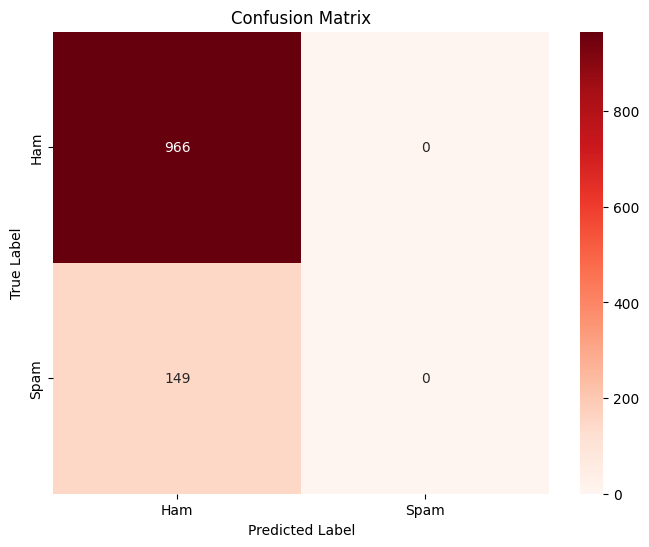

In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Function to plot confusion matrix with red color scheme
def plot_confusion_matrix(data, counts):
    # Get true labels
    y_true = data['label']
    # Predict labels using the trained model
    y_pred = [classify_message(tokens, counts) for tokens in data['tokens']]
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix with red color scheme
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Reds", fmt="d", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix with red color scheme
plot_confusion_matrix(test_data, ngram_counts)
